# Object category recognition - Caltech-256

Lorenzo Doneda - 806727  
Luca Maggi - 866654  
Daniele Rizzo - 872359  

1. Librerie e dataset
2. Rete neurale convoluzione
3. Transfer learning con DenseNet121
4. Transfer learning con VGG16

## Librerie e dataset

Si importano numerose librerie e funzioni con lo scopo di trattare i dati e sviluppare adeguati modelli di classificazione

In [ ]:
# File management
from google.colab import drive
import tarfile
from shutil import copyfile
import os

# Machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils import class_weight

# Deep learning
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, Sequential
from tensorflow import keras
from tensorflow.keras import regularizers
from keras.applications.densenet import preprocess_input
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Conv2D, MaxPool2D, Flatten
import keras.backend as K
from tensorflow.keras.optimizers import Adam

# Gestione dati e visualizzazione
import cv2 as cv
import random
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tqdm import tqdm_notebook

Si definisce inoltre una funzione in modo da poter mostrare graficamente l'evoluzione del valore di loss e accuracy di un modello addestrato.

In [ ]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

I dati presenti con una scorciatoia nell'archivio Drive vengono importati all'interno della sessione utilizzando le apposite funzioni della libreria colab

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


I dati sono distribuiti compressi in formato tar e per utilizzarli si effettua un'estrazione di questi con le funzioni della libreria tarfile

In [ ]:
copyfile('/content/gdrive/MyDrive/256_ObjectCategories.tar', './256_ObjectCategorie.tar') #Progetto AML/
tar = tarfile.open('256_ObjectCategorie.tar')
tar.extractall()
tar.close()

Estratti, si può notare che all'interno della cartella 256_ObjectCategorie sono presenti tante cartelle quante classi, ognuna contenente le immagini relative alle singole classi. Ogni cartella è denominata coerentemente con il contenuto e pertanto è possibile lavorare con essere utilizzando la funzione image_dataset_from_directory di Keras che consente di definire oggetti Dataset direttamente dalle cartelle. 

In [ ]:
base_path = './256_ObjectCategories/'
Y = list()
for obj in tqdm_notebook(os.listdir(base_path)):
  length = len(os.listdir(base_path+obj))
  Y.append([int(obj.split('.')[0])]*length)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/257 [00:00<?, ?it/s]

In [ ]:
YY = np.hstack(np.array(Y)).reshape(-1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(np.hstack(YY)),
    y = np.hstack(YY))

In [ ]:
cl = {i:j for i,j in zip(range(257), class_weights)} #classweight to dictionary

In [ ]:
df = image_dataset_from_directory(
    directory='/content/256_ObjectCategories', label_mode='categorical', batch_size= 128)

Found 30607 files belonging to 257 classes.


Il numero di immagini totale è di 30607 per 257 classi e vengono divise in batch di dimensione 128 in modo da alleggerire l'utilizzo della memoria e della capacità di calcolo. Per sviluppare i diversi modelli di classificazione e testarne le capacità si dividono i dati in tre diversi set: train, validation e set, utilizzando i metodi take e skip.

In [ ]:
train_ds = df.take(180)    # 234 batches totali, train = 180 batches = 77%
val_ds = df.skip(180).take(30) # validation = 30 batches = 13%
test_ds = df.skip(180).skip(30) # test = 24 batches = 10%

### Esplorazione dati

Come descritto in precedenza i dati sono suddivisi in batch di dimensione 128 con immagini in formato $256\times256\times3$. Data questa dimensione sarà importante nel caso si vogliano utilizzare tecniche di transfer learning, effettuare un ridimensionamento.

In [ ]:
input_shape=(256,256,3)

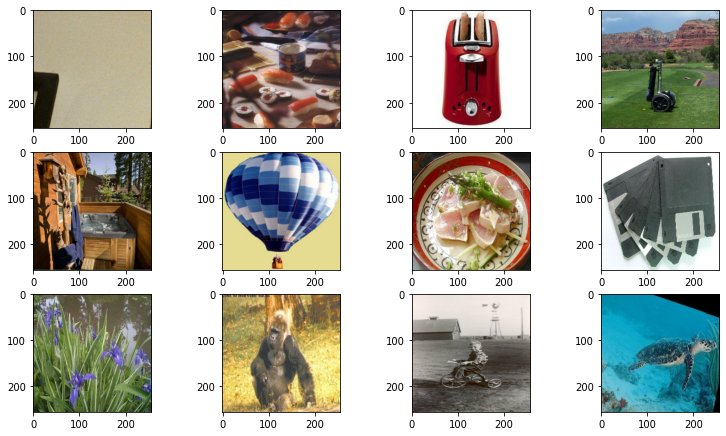

In [ ]:
plt.figure(figsize=[13,10])
count = 1
while True:
  obj = next(iter(df))
  for image in obj[0]:
    plt.subplot(4,4,count)
    plt.imshow(np.int32(image).reshape(256,256,3))
    count+=1
    if count >12:
      break
  break

Come si può notare da questi 12 esempi di oggetti, il dataset contiene immagini molto diverse tra loro e di conseguenza una delle sfide del modello da sviluppare è che questo sia in grado di adattarsi a molte situazioni diverse.

## Rete neurale convoluzionale

Una scelta molto importante per lo sviluppo di una rete neurale è la selezione dei parametri iniziali. Una buona norma è effettuare un'inizializzazione casuale con varianza e intervallo costanti. Una tecnica particolarmente utilizzata ed efficace è l'inizializzazione con distribuzione uniforme Glorot. 

In [ ]:
initializer = tf.keras.initializers.GlorotUniform(seed=1234) 

Si passa quindi alla costruzione del modello. Come primo passaggio si impostano alcune operazioni di data augmentation. Queste vengono utilizzate per aumentare la variabilità all'interno dei dati in modo da migliorare la capacità del modello e da contrastare un possibile overfitting. Le operazioni considerate sono tali da non distruggere la relazione di coerenza tra le immagini e le loro classi. Si effettuano modifiche del contrasto e rotazioni. 

Successivamente si effettua una normalizzazione nell'intervallo $[0,1]$. Questa consente di evitare che alcune features di input abbiano un maggior peso per la stima dei parametri inficiando l'apprendimento del modello. Dato il dominio dei dati, tensori di rango 3 con valori nell'intervallo $[0,255]$, per normalizzare è sufficiente dividere questi oggetti per $255$.  

Si passa quindi alla struttura della rete neurale. L'idea è quella di utilizzarre più blocchi convoluzionali in sequenza in modo da poter ottenere delle rappresentazioni di alto livello delle immagini con una rete non particolarmente profonda e così da allontanarsi dal problema del vanishing gradient. Con il procedere della rete si utilizzano gradualmente più filtri, partendo dai 16 iniziali e raddoppiandoli in ogni layer successivo. La dimensione dei filtri rimane invece costante pari a $3\times3$. Si utilizza inoltre uno stride pari a 1 in modo da non ridurre utleriormente la dimensione della rappresentazione e si effettua un'operazione di zero padding in modo da conservare in output la dimensione di input. Altro particolare è l'utilizzo di layer di batch normalization in modo da normalizzare di volta in volta i dati processati dai layer convoluzionali. Per gli utlimi due layer convoluzionali viene inoltre definito un dropout con probabilità $0.3$.  
Dopo quattro building block così strutturati si effettua un'operazione di flattening in modo da distruggere l'informazione spaziale e da poter elaborare questa con layer fully connected. Si utilizza un layer composto da 256 neuroni con dropout con probabilità 0.2, prima di un layer di output con funziona di attivazione softmax.  
Le funzioni di attivazione sono una componente fondamentale per lo sviluppo di un modello di deep learning. Nei primi layer convoluzionali si utilizza la funzione `selu`, una variante della ReLU che consente di evitare il problema del dying neurons particolarmente importante per non perdere capacità di rappresentazione del modello con pochi neuroni. Con l'aumentare del numero di filtri e neuroni questo problema risulta essere meno pericoloso e si utilizza la funzione ReLU. Come detto in precedenza, nel layer di output si utilizza la funzione softmax adatta per effettuare una classificazione multi labels.


In [ ]:
filters = 16
lr = .001
epochs = 20
batch_size = 32
decay = lr/epochs
adam = Adam(learning_rate=lr, decay=decay)
img_size=256

model = Sequential()

# Input and data augmentation
model.add(tf.keras.layers.RandomContrast(1, seed=None))
model.add(tf.keras.layers.RandomRotation((-0.2, 0.2), fill_mode="reflect",
                                     interpolation="bilinear", 
                                     seed=None, fill_value=0.0))

model.add(tf.keras.layers.Rescaling(1./255))
model.add(keras.Input(shape = (img_size,img_size,3)))

# Block 1
model.add(Conv2D(filters = filters, kernel_size= (3,3), 
                 input_shape = (img_size,img_size,3), padding = 'same',
                 kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(MaxPool2D(pool_size = (2,2)))

# Block 2
model.add(Conv2D(filters = filters*2, kernel_size= (3,3), 
                 input_shape = (img_size,img_size,3), padding = 'same', 
                 kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(MaxPool2D(pool_size = (2,2)))

# Block 3
model.add(Conv2D(filters = filters*4, kernel_size= (3,3), 
                 input_shape = (img_size,img_size,3), padding = 'same', 
                 kernel_initializer=initializer))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2,2)))

# Block 4
model.add(Conv2D(filters = filters*8, kernel_size= (3,3), 
                 input_shape = (img_size,img_size,3), padding = 'same', 
                 kernel_initializer=initializer))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Flatten())

model.add(Dense(256, kernel_initializer=initializer))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Dense(257,activation='softmax'))

La fase fondamentale per lo sviluppo di una rete neurale è l'apprendimento. Per effettuare questa fase è necessario definire determinate condizioni. Innanzitutto si seleziona una funzione di loss da minimizzare durante l'apprendimento. Data la funzione di output scelta si utilizza la categorical crossentropy, che si accoppia con essa e permette di addestrare un modello per classificazione multi labels. Per questo procedimento si sceglie come algoritmo di ottimizzazione `adam`. Questo algoritmo consente di sfruttare sia il principio del momento del gradiente che un learning rate adattivo in modo da effettuare una discesa del gradiente particolarmente robusta rispetto ai molti problemi che si possono incontrare in questo precesso. Infine durante il training del modello si monitorano sia la top1 accuracy che, data la numerosità delle classi, anche la top5 accuracy.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

In [ ]:
model.build((1,256,256,3))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_contrast_4 (RandomCo  (256, 256, 3)            0         
 ntrast)                                                         
                                                                 
 random_rotation_3 (RandomRo  (256, 256, 3)            0         
 tation)                                                         
                                                                 
 rescaling_3 (Rescaling)     (256, 256, 3)             0         
                                                                 
 input_4 (InputLayer)        multiple                  0         
                                                                 
 conv2d_12 (Conv2D)          multiple                  448       
                                                                 
 batch_normalization_14 (Bat  multiple                

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss', mode='min', verbose=1, patience = 5) 

In [ ]:
epochs = 30

network_history = model.fit(train_ds,
                            validation_data = val_ds, 
                            epochs=epochs, batch_size=128, 
                            callbacks = [es], class_weight= cl
                            )

Epoch 1/30
180/180 [==============================] - 105s 569ms/step - loss: 5.2678 - accuracy: 0.0454 - top_k_categorical_accuracy: 0.1233 - val_loss: 5.5345 - val_accuracy: 0.0049 - val_top_k_categorical_accuracy: 0.0565
Epoch 2/30
180/180 [==============================] - 99s 542ms/step - loss: 4.7875 - accuracy: 0.0960 - top_k_categorical_accuracy: 0.2259 - val_loss: 5.2190 - val_accuracy: 0.0180 - val_top_k_categorical_accuracy: 0.1318
Epoch 3/30
180/180 [==============================] - 91s 495ms/step - loss: 4.4944 - accuracy: 0.1346 - top_k_categorical_accuracy: 0.2932 - val_loss: 4.9060 - val_accuracy: 0.0779 - val_top_k_categorical_accuracy: 0.2284
Epoch 4/30
180/180 [==============================] - 91s 495ms/step - loss: 4.2931 - accuracy: 0.1670 - top_k_categorical_accuracy: 0.3394 - val_loss: 4.6988 - val_accuracy: 0.1365 - val_top_k_categorical_accuracy: 0.2807
Epoch 5/30
180/180 [==============================] - 91s 496ms/step - loss: 4.1003 - accuracy: 0.1935 - to

Il training svolto pe venti epoche mostra una certa difficoltà del modello nell'apprendere i dati di train forniti. Ciò è probabilmente dovuto al fatto che il dataset è particolarmente articolato e le risorse a disposizione non sono tali da sviluppare da zero un modello sufficientemente capace. Non si osservano comunque problemi di overfitting con prestazioni analoghe sia sul train set che sul validation set. Si approfondisce il processo di apprendimento analizzando il valore di loss e di accuracy nel corso delle diverse epoche.

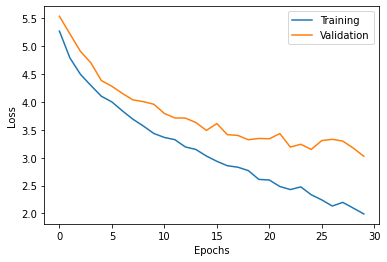

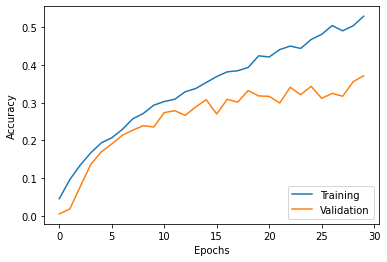

In [ ]:
plot_history(network_history)

I grafici confermano le impressioni numeriche. Non si nota la presenza di overfitting e le prestazioni, così come la capacità di apprendimento del modello, risultano contenute. 

Si testano infine le prestazioni del modello con un set di test

In [ ]:
score = model.evaluate(test_ds, verbose=0)
print('Test loss: %1.4f'%score[0])
print('Test accuracy: %1.4f'%score[1])
print('Test top-5 accuracy: %1.4f'%score[2])

Test loss: 3.2286
Test accuracy: 0.3292
Test top-5 accuracy: 0.5374


Le prestazioni risultano essere particolarmente contenute, in linea però con quelle osservate in fase di apprendimento.

## Transfer learning - DenseNet121

Data la complessità del dataset e l'indisponibilità delle risorse necessarie per lo sviluppo di un modello da zero si percorrono strade alternative. Una possibilità è quella del trasfer learning, cioè utilizzare la capacità di rappresentazione di modelli pre addestrati per definire modelli specializzati sul problema particolare con layer aggiuntivi.  
Il modello di base che si sceglie di utilizzare è densenet121. In particolare si utilizza con i parametri stimati sul dataset imagenet, un dataset di immagini estremamente vasto e di riferimento per i modelli di computer vision.

In [ ]:
convBase = DenseNet121(include_top=False, weights="imagenet", input_shape=(227,227,3))
convBase.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 233, 233, 3)  0          ['input_6[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 114, 114, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

Si può apprezzare come il modello sia particolarmente importante in termini di dimensione. Sono presenti 16 blocchi con layer convoluzionali, attivazione relu e batch normalization. La dimensione di input richiesta è $227 \times 227 \times 3$ e si sceglie di utilizzare il modello pre addestrato nella sua interezza a meno del layer `dense` di output. Questa scelta è legata al fatto che il dataset imagenet è particolarmente simile al dataset di riferimento e quindi si utilizzano le features di alto livello come rappresentazione per le nostre immagini. Si impostano quindi i layer pre addestrati congelati per non essere addestrati nuovamente e si specializza il modello con due layer composti da 2048 e 512 neuroni, con un dropout con probabilità pari a 0.2 sul primo di questi e funzione di attivazione ReLU.

In [ ]:
for layer in convBase.layers: 
  layer.trainable = False

In [ ]:
inputs = keras.Input(shape=(256, 256, 3))
x = inputs

# preprocessing
x = keras.applications.densenet.preprocess_input(x)

# data augmentation

x = layers.RandomTranslation(height_factor = (-0.2, 0.2), width_factor = (-0.2, 0.2), 
                             fill_mode="reflect", interpolation="bilinear", 
                             seed=None, fill_value=0.0,) (x)

x = layers.RandomRotation((-0.2, 0.2), fill_mode="reflect",
                          interpolation="bilinear",seed=None,fill_value=0.0)(x)

x = layers.Resizing(227, 227, interpolation="bilinear", 
                    crop_to_aspect_ratio=False) (x)

#Convbase
x = convBase(x)
x = layers.Flatten()(x)

# Fine tuning
x = keras.layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu')(x)

outputs = keras.layers.Dense(257, activation='softmax')(x)

In [ ]:
new_model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
new_model.build((1,227,227,3))

In [ ]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 random_translation_1 (Rando  (None, 256, 256, 3)      0         
 mTranslation)                                               

Si replicano le condizioni di addestramento viste in precedenza per il modello sviluppato ex novo

In [ ]:
new_model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(k=5)])
epochs = 20
network_history_new_model = new_model.fit(train_ds,
                            validation_data = val_ds, 
                            epochs=epochs,  callbacks = [es], 
                            class_weight= cl)

Epoch 1/20
180/180 [==============================] - 248s 1s/step - loss: 6.7913 - accuracy: 0.0854 - top_k_categorical_accuracy: 0.1926 - val_loss: 2.5465 - val_accuracy: 0.4286 - val_top_k_categorical_accuracy: 0.6732
Epoch 2/20
180/180 [==============================] - 222s 1s/step - loss: 2.7136 - accuracy: 0.3819 - top_k_categorical_accuracy: 0.6429 - val_loss: 1.5865 - val_accuracy: 0.5906 - val_top_k_categorical_accuracy: 0.8313
Epoch 3/20
180/180 [==============================] - 223s 1s/step - loss: 2.1876 - accuracy: 0.4798 - top_k_categorical_accuracy: 0.7395 - val_loss: 1.4422 - val_accuracy: 0.6352 - val_top_k_categorical_accuracy: 0.8500
Epoch 4/20
180/180 [==============================] - 223s 1s/step - loss: 1.9678 - accuracy: 0.5275 - top_k_categorical_accuracy: 0.7749 - val_loss: 1.2998 - val_accuracy: 0.6667 - val_top_k_categorical_accuracy: 0.8732
Epoch 5/20
180/180 [==============================] - 223s 1s/step - loss: 1.8139 - accuracy: 0.5554 - top_k_categor

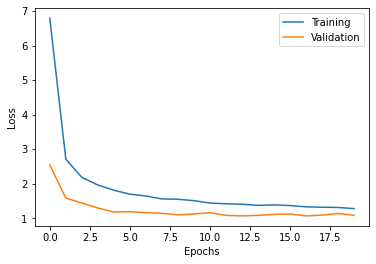

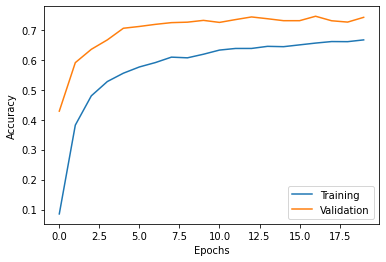

In [ ]:
plot_history(network_history_new_model)

In [ ]:
score = new_model.evaluate(test_ds, verbose=0)
print('Test loss: %1.4f'%score[0])
print('Test accuracy: %1.4f'%score[1])
print('Test top-5 accuracy: %1.4f'%score[2])

Test loss: 1.1285
Test accuracy: 0.7392
Test top-5 accuracy: 0.8967


## Fine tuning - DesneNet121

Nel primo modello sviluppato basato su DenseNet121 si sono considerati tutti i parametri pre-addestrati come bloccati lasciando ai due layer fully connected il compito di adattare il modello sui dati a disposizione. Questa scelta ha portato ad una certa difficoltà del modello di apprendere su questi dati di training. Per lasciare più libertà e flessibilità al modello si effettua fine tuning in modo da addestrare nuovamente i layer relativi al blocco convoluzionale `conv5`.

In [ ]:
convBase = DenseNet121(include_top=False, weights="imagenet", input_shape=(227,227,3))

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
convBase.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 233, 233, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 114, 114, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
for layer in convBase.layers: 
  if 'conv5' not in layer.name:
    layer.trainable = False

Si replicano le condizioni viste nei casi precedenti in modo da poter effettuare un confronto di modelli analoghi

In [ ]:
inputs = keras.Input(shape=(256, 256, 3))
x = inputs

# preprocessing
x = keras.applications.densenet.preprocess_input(x)

# # data augmentation

x = layers.RandomTranslation(height_factor = (-0.2, 0.2), width_factor = (-0.2, 0.2), 
                             fill_mode="reflect", interpolation="bilinear", 
                             seed=None, fill_value=0.0,) (x)

x = layers.RandomRotation((-0.2, 0.2), fill_mode="reflect",
                          interpolation="bilinear",seed=None,fill_value=0.0)(x)

x = layers.Resizing(227, 227, interpolation="bilinear", 
                    crop_to_aspect_ratio=False)(x)

#Convbase
x = convBase(x)
x = layers.Flatten()(x)

# Fine tuning
x = keras.layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu')(x)

outputs = keras.layers.Dense(257, activation='softmax')(x)

In [ ]:
new_model_c5 = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
new_model_c5.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 random_translation (RandomT  (None, 256, 256, 3)      0         
 ranslation)                                               

Si replicano le condizioni di addestramento viste in precedenza per il modello sviluppato ex novo

In [ ]:
new_model_c5.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)])
epochs = 20
network_history_c5 = new_model_c5.fit(train_ds,
                            validation_data = val_ds, 
                            epochs=epochs, batch_size=128, 
                            callbacks = [es], class_weight= cl
                            )

Epoch 1/20
180/180 [==============================] - 272s 1s/step - loss: 5.2081 - accuracy: 0.0703 - top_k_categorical_accuracy: 0.1693 - val_loss: 3.3509 - val_accuracy: 0.2362 - val_top_k_categorical_accuracy: 0.4958
Epoch 2/20
180/180 [==============================] - 244s 1s/step - loss: 2.8789 - accuracy: 0.3404 - top_k_categorical_accuracy: 0.6126 - val_loss: 2.0482 - val_accuracy: 0.5005 - val_top_k_categorical_accuracy: 0.7661
Epoch 3/20
180/180 [==============================] - 244s 1s/step - loss: 2.0601 - accuracy: 0.5033 - top_k_categorical_accuracy: 0.7648 - val_loss: 1.5473 - val_accuracy: 0.6190 - val_top_k_categorical_accuracy: 0.8469
Epoch 4/20
180/180 [==============================] - 244s 1s/step - loss: 1.7509 - accuracy: 0.5715 - top_k_categorical_accuracy: 0.8151 - val_loss: 1.4231 - val_accuracy: 0.6576 - val_top_k_categorical_accuracy: 0.8607
Epoch 5/20
180/180 [==============================] - 244s 1s/step - loss: 1.5408 - accuracy: 0.6148 - top_k_categor

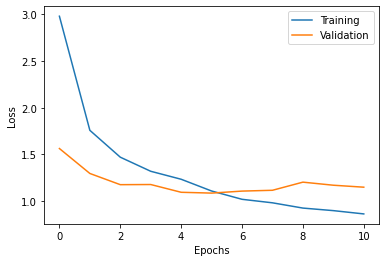

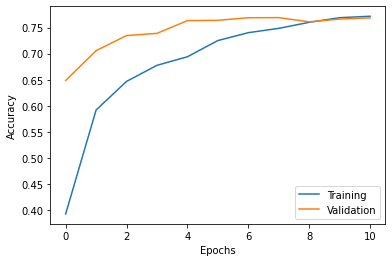

In [ ]:
plot_history(network_history_c5)

Si può osservare un miglioramento rispetto al modello precedente. Il modello si è adattato bene sui dati di training e, anche grazie al criterio di early stopping, il modello non mostra overfitting.

In [ ]:
score = new_model_c5.evaluate(test_ds, verbose=0)
print('Test loss: %1.4f'%score[0])
print('Test accuracy: %1.4f'%score[1])
print('Test top-5 accuracy: %1.4f'%score[2])

Test loss: 1.3095
Test accuracy: 0.7542
Test top-5 accuracy: 0.8967


Anche sul test si osservano risultati analoghi a quanto visto per l'insieme di validazione.

## Transfer learning - VGG16

Al fine di confrontare i risultati ottenuti con l'architettura DenseNet121, si sviluppa un modello con transfer learning e l'architettura VGG16. Si replicano le condizioni viste per DenseNet121 senza effettuare fine tuning e conservando tutti i parametri pre-addestrati con imagenet a meno dei layer fully connected.

In [ ]:
from tensorflow.keras.applications import VGG16
convBase = VGG16(include_top=False, weights="imagenet", input_shape=(227,227,3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
convBase.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Anche in questo caso si specializza il modello esclusivamente utilizzando due layer fully connected, oltre al layer di output, composti da 2048 e 512 neuroni con il primo regolato da un dropout di probabilità $p=0.2$. La funzione di attivazione utilizzata è la ReLU.

In [ ]:
for layer in convBase.layers: 
    layer.trainable = False

In [ ]:
inputs = keras.Input(shape=(256, 256, 3))
x = inputs

# preprocessing
x = keras.applications.vgg16.preprocess_input(x)

# data augmentation

x = layers.RandomTranslation(height_factor = (-0.2, 0.2), width_factor = (-0.2, 0.2), 
                             fill_mode="reflect", interpolation="bilinear", 
                             seed=None, fill_value=0.0,) (x)

x = layers.RandomRotation((-0.2, 0.2), fill_mode="reflect",
                          interpolation="bilinear",seed=None,fill_value=0.0)(x)

x = layers.Resizing(227, 227, interpolation="bilinear", 
                    crop_to_aspect_ratio=False) (x)

#Convbase
x = convBase(x)
x = layers.Flatten()(x)

# Fine tuning
x = keras.layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu')(x)

outputs = keras.layers.Dense(257, activation='softmax')(x)

In [ ]:
new_model_VGG = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
new_model_VGG.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 random_translation_2 (Rando  (None, 256, 256, 3)      0         
 mTranslation)                                                   
                                                                 
 random_rotation_6 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                   

Si replicano le condizioni di addestramento viste in precedenza per il modello sviluppato ex novo

In [ ]:
new_model_VGG.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)])
epochs = 20
network_history = new_model_VGG.fit(train_ds,
                            validation_data = val_ds, 
                            epochs=epochs,
                            callbacks = [es], class_weight= cl
                            )

Epoch 1/20
180/180 [==============================] - 380s 2s/step - loss: 13.4624 - accuracy: 0.0105 - top_k_categorical_accuracy: 0.0367 - val_loss: 5.2948 - val_accuracy: 0.0328 - val_top_k_categorical_accuracy: 0.0865
Epoch 2/20
180/180 [==============================] - 351s 2s/step - loss: 5.2201 - accuracy: 0.0579 - top_k_categorical_accuracy: 0.1210 - val_loss: 4.6255 - val_accuracy: 0.1339 - val_top_k_categorical_accuracy: 0.2667
Epoch 3/20
180/180 [==============================] - 351s 2s/step - loss: 4.4928 - accuracy: 0.1543 - top_k_categorical_accuracy: 0.2921 - val_loss: 3.4435 - val_accuracy: 0.2896 - val_top_k_categorical_accuracy: 0.4859
Epoch 4/20
180/180 [==============================] - 350s 2s/step - loss: 3.5641 - accuracy: 0.2571 - top_k_categorical_accuracy: 0.4654 - val_loss: 2.6404 - val_accuracy: 0.4073 - val_top_k_categorical_accuracy: 0.6508
Epoch 5/20
180/180 [==============================] - 350s 2s/step - loss: 2.9703 - accuracy: 0.3450 - top_k_catego

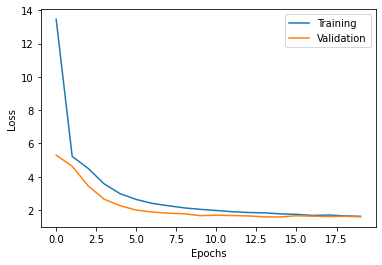

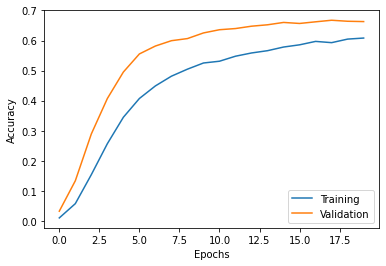

In [ ]:
plot_history(network_history)

I risultati ottenuti con quest'ultimo modello risultano essere analoghi a quelli ottenuti in condizioni analoghe da DenseNet121. Anche a questo quindi potrebbe essere opportuno fornire maggiore flessibilità per l'apprendimento dei parametri.

In [ ]:
score = new_model_VGG.evaluate(test_ds, verbose=0)
print('Test loss: %1.4f'%score[0])
print('Test accuracy: %1.4f'%score[1])
print('Test top-5 accuracy: %1.4f'%score[2])

Test loss: 1.6813
Test accuracy: 0.6552
Test top-5 accuracy: 0.8452
